# Stability Package

## Testing Script

In [108]:
def process(training_prop, model, experiment, path_to_ml_data):
    """
    Args:
        training_prop (str) - 'Ef' if models trained on formation energies; 'Ed' if decomposition energies
        model (str) - ML model
        experiment (str) - 'allMP', 'LiMnTMO', or 'smact'
        path_to_ml_data (os.PathLike) - path to ml_data directory in .../TestStabilityML/mlstabilitytest/ml_data
    
    Returns:
        Runs all relevant analyses
        Prints a summary
    """
    if (model == 'CGCNN') and (experiment == 'smact'):
        print('CGCNN cannot be applied directly to the SMACT problem because the structures are not known')
        return
    if ('random' in experiment) and (training_prop == 'Ed'):
        print('Random perturbations only apply to models trained on Ef as written')
        return
    if (experiment == 'classifier') and (training_prop == 'Ef'):
        print('Classifier experiment only applies to training on Ed')
        return
    if (model == 'CGCNN') and (training_prop == 'Ed'):
        print('CGCNN not trained on Ed')
        return
    data_dir = os.path.join(path_to_ml_data, training_prop, experiment, model)
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
        
    data_file = 'ml_input.json'
    finput = os.path.join(data_dir, data_file)
    if 'random' in experiment:
        src = finput.replace(experiment, 'allMP')
        copyfile(src, finput)
    if not os.path.exists(finput):
        print('missing data for %s-%s' % (model, experiment))
        return
    if training_prop == 'Ef':
        nprocs = 'all'
        obj = StabilityAnalysis(data_dir,
                                data_file,
                                experiment,
                                nprocs=nprocs)
    elif training_prop == 'Ed':
        obj = EdAnalysis(data_dir,
                         data_file,
                         experiment)
    else:
        raise NotImplementedError
    obj.results_summary
    print('got results')
    return

In [109]:
import os
from mlstabilitytest.stability.StabilityAnalysis import StabilityAnalysis, EdAnalysis
from shutil import copyfile

here = './mlstabilitytest/'

models = ['ElFrac', 'Meredig', 'Magpie', 'AutoMat', 'ElemNet', 'Roost', 
              'CGCNN']
experiments = ['LiMnTMO', 'allMP', 'smact',
               'random1', 'random2', 'random3',
               'classifier']
training_props = ['Ef', 'Ed']
path_to_ml_data = os.path.join(here, 'ml_data')

for training_prop in training_props:
    print('\n____ models trained on %s ____\n' % training_prop)
    for experiment in experiments:
        print('\n ~~~ %s ~~~\n' % experiment)
        experiment_dir = os.path.join(path_to_ml_data, training_prop, experiment)
        if (('random' not in experiment) and (training_prop == 'Ed')) or ((experiment != 'classifier') and (training_prop == 'Ef')):
            if not os.path.exists(experiment_dir):
                os.mkdir(experiment_dir)
        for model in models:
            print('\n %s ' % model)
            process(training_prop, model, experiment, path_to_ml_data)
            


____ models trained on Ef ____


 ~~~ LiMnTMO ~~~


 ElFrac 

Checking input data...
Data looks good.
Time elapsed = 0 s.

Reading existing results file: ./mlstabilitytest/ml_data/Ef/LiMnTMO/ElFrac/ml_results.json

Summarizing performance...

MAE on formation enthalpy = 0.099 eV/atom
MAE on decomposition enthalpy = 0.064 eV/atom

Classifying stable or unstable:
Precision = 0.062
Recall = 0.222
Accuracy = 0.861
F1 = 0.098
FPR = 0.116

Confusion matrix:
TP | FP
FN | TN = 
2 | 30
7 | 228

Time elapsed = 0 s
got results

 Meredig 

Checking input data...
Data looks good.
Time elapsed = 0 s.

Reading existing results file: ./mlstabilitytest/ml_data/Ef/LiMnTMO/Meredig/ml_results.json

Summarizing performance...

MAE on formation enthalpy = 0.098 eV/atom
MAE on decomposition enthalpy = 0.065 eV/atom

Classifying stable or unstable:
Precision = 0.062
Recall = 0.222
Accuracy = 0.861
F1 = 0.098
FPR = 0.116

Confusion matrix:
TP | FP
FN | TN = 
2 | 30
7 | 228

Time elapsed = 0 s
got results

 Ma

KeyboardInterrupt: 

## Train a Models

In [110]:
from os.path import dirname, abspath, join
from sys import argv
import json
from mlstabilitytest.training.process import problem_dictionary, target_list, model_dictionary

base_path = dirname(dirname(abspath(__file__)))
output_base_path = join(base_path, "mlstabilitytest", "ml_data")


def main(argv):
    """
    Train models on the MP data, and make predictions in a format suitable for hull analysis

    """
    try:
        problem = argv[1]
        target = argv[2]
        model_name = argv[3]
    except IndexError:
        print("Arguments should be Problem Target Model")
        exit(1)

    try:
        train_func = problem_dictionary[problem]
    except KeyError:
        print("Invalid problem selection {}. Valid choices are {}".format(problem,
                                                                          ", ".join(problem_dictionary.keys())))
        exit(1)
    try:
        if not target in target_list:
            raise ValueError
    except ValueError:
        print("Invalid target selection. Valid choices are {}".format(
            ", ".join(target_list)))
        exit(1)

    try:
        model = model_dictionary[model_name](target)
    except KeyError:
        print("Invalid model selection. Valid choices are {}".format(
            ", ".join(model_dictionary.keys())))
        exit(1)

    output_file = join(output_base_path, target, problem,
                       model_name, 'ml_input.json')

    print("Training {} to predict {} using the {} dataset".format(
        model_name, target, problem))

    predictions = train_func(model, target)

    print("Training complete, saving predictions to {}".format(output_file))
    with open(output_file, 'w') as f:
        json.dump(predictions, f)


if __name__ == '__main__':
    main(argv)


NameError: name '__file__' is not defined

## Testing script for decomposition only

In [111]:
import os
from mlstabilitytest.stability.StabilityAnalysis import EdAnalysis
from shutil import copyfile

here = './mlstabilitytest/'

# models = ['ElFrac', 'Meredig', 'Magpie', 'AutoMat', 'ElemNet', 'Roost', 
#               'CGCNN']
model = 'Magpie'

experiment = 'LiMnTMO'
training_prop = 'Ed'
path_to_ml_data = os.path.join(here, 'ml_data')


data_dir = os.path.join(path_to_ml_data, training_prop, experiment, model)
data_file = 'ml_input.json'

obj = EdAnalysis(data_dir, data_file, experiment)

obj.results_summary


Checking input data...
Data looks good.
Time elapsed = 0 s.

Reading existing results file: ./mlstabilitytest/ml_data/Ed/LiMnTMO/Magpie/ml_results.json

Summarizing performance...

MAE on decomposition enthalpy = 0.027 eV/atom


Classifying stable or unstable:
Precision = 0.000
Recall = 0.000
Accuracy = 0.966
F1 = 0.000
FPR = 0.000

Confusion matrix:
TP | FP
FN | TN = 
0 | 0
9 | 258

Time elapsed = 0 s


## Database

## Spaces

In [114]:
import mlstabilitytest.mp_data.data as dat

space = dat.spaces()
ef = dat.Ef()

## Hull

In [25]:
hull_in = dat.hullin()
hull_out = dat.hullout()

# Using Pymatgen to calculate Decomposition Energy

In [117]:
from pymatgen.core import Composition, Element
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDEntry

# Define the chemical formula and formation energy of the material
chemical_formula = "Li2O2"
formation_energy = -587.64  # eV/atom

# Create a Composition object from the chemical formula
composition = Composition(chemical_formula)

# Create an Element object for each element in the composition
elements = [Element(e) for e in composition.elements]

# Create a list of entries for the elements
entries = [PDEntry(element.symbol, 0.0) for element in elements]

# Add an entry for the material of interest with its formation energy
entries.append(PDEntry(composition, formation_energy))

# Create a PhaseDiagram object from the entries
phase_diagram = PhaseDiagram(entries)


# Script

https://github.com/materialsproject/pymatgen/blob/master/pymatgen/analysis/phase_diagram.py

<Axes: xlabel='Fraction', ylabel='Formation energy (eV/atom)'>

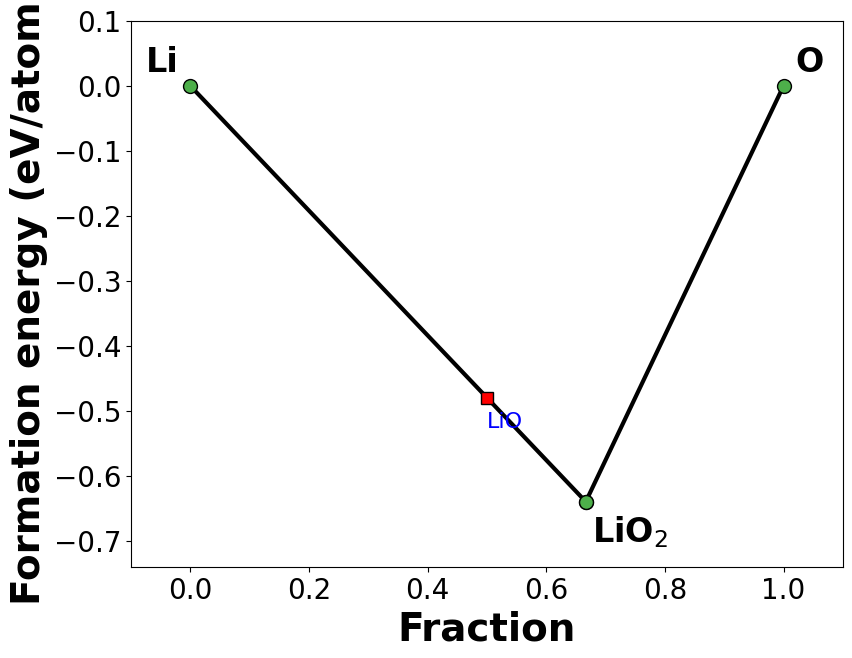

In [1]:
from pymatgen.ext.matproj import MPRester
from pymatgen.core import Composition, Element
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter, PDEntry

%matplotlib inline

# Get unprocessed_entries using pymatgen.borg or other means.

# Create some example entries
entries = [
    PDEntry(Composition("Li"), -2.9588, name="Li"),
    PDEntry(Composition("Li2O"), -4.9176, name="Li2O"),
    PDEntry(Composition("Li2O2"), -5.8764, name="Li2O2"),
    PDEntry(Composition("Li2O3"), -6.8352, name="Li2O3"),
    PDEntry(Composition("LiO"), -3.9176, name="LiO"),
    PDEntry(Composition("LiO2"), -4.8764, name="LiO2"),
    PDEntry(Composition("Li2O3"), -5.8352, name="Li2O3"),
    # Add an entry for pure O
    PDEntry(Composition("O"), 0.0, name="O"),
]

# Create a phase diagram
pd = PhaseDiagram(entries)

pd.get_plot(backend = "matplotlib")

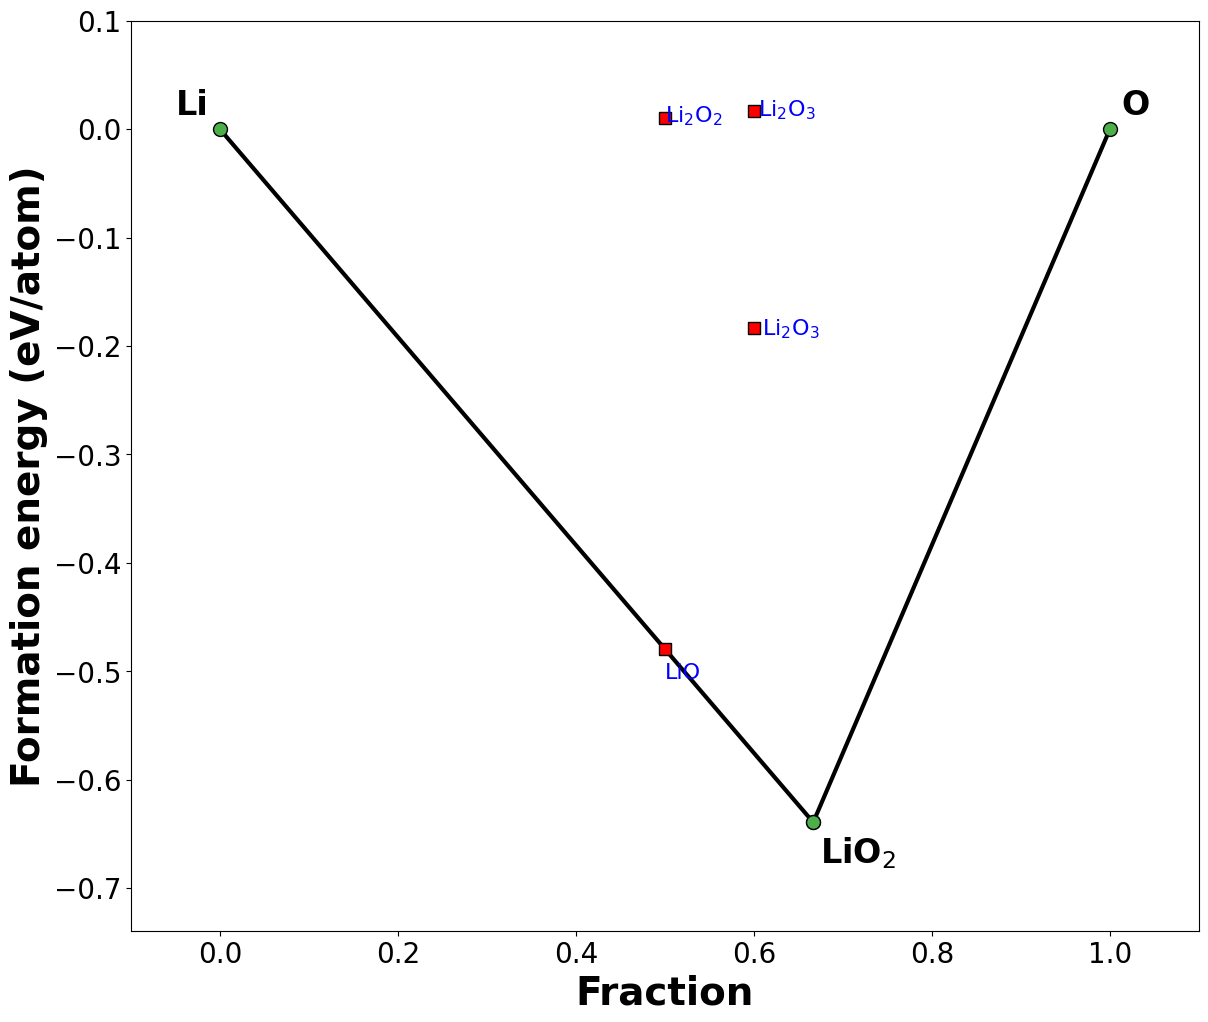

In [4]:
plotter = PDPlotter(pd, backend = "matplotlib", show_unstable=True)
plotter.write_image('Phase.png')

In [5]:
for e in entries:
    decomp, ehull = pd.get_decomp_and_e_above_hull(e)
    print(decomp)

{PDEntry : Li1 with energy = -2.9588: 1.0}
{PDEntry : Li1 O2 with energy = -4.8764: 0.5, PDEntry : Li1 with energy = -2.9588: 0.5}
{PDEntry : Li1 O2 with energy = -4.8764: 0.75, PDEntry : Li1 with energy = -2.9588: 0.25}
{PDEntry : Li1 O2 with energy = -4.8764: 0.8999999999999999, PDEntry : Li1 with energy = -2.9588: 0.10000000000000009}
{PDEntry : Li1 O2 with energy = -4.8764: 0.75, PDEntry : Li1 with energy = -2.9588: 0.25}
{PDEntry : Li1 O2 with energy = -4.8764: 1.0}
{PDEntry : Li1 O2 with energy = -4.8764: 0.8999999999999999, PDEntry : Li1 with energy = -2.9588: 0.10000000000000009}
{PDEntry : O1 (O) with energy = 0.0000: 1.0}


In [6]:
for e in entries:
    decomp, phase_sep = pd.get_decomp_and_phase_separation_energy(e)
    print(decomp)

{PDEntry : Li1 with energy = -2.9588: 1.0}
{PDEntry : Li1 O2 with energy = -4.8764: 0.5, PDEntry : Li1 with energy = -2.9588: 0.5}
{PDEntry : Li1 O2 with energy = -4.8764: 0.75, PDEntry : Li1 with energy = -2.9588: 0.25}
{PDEntry : Li1 O2 with energy = -4.8764: 0.8999999999999999, PDEntry : Li1 with energy = -2.9588: 0.10000000000000009}
{PDEntry : Li1 O2 with energy = -4.8764: 0.75, PDEntry : Li1 with energy = -2.9588: 0.25}
{PDEntry : Li1 O1 (LiO) with energy = -3.9176: 0.6666666666666667, PDEntry : O1 (O) with energy = 0.0000: 0.33333333333333326}
{PDEntry : Li1 O2 with energy = -4.8764: 0.8999999999999999, PDEntry : Li1 with energy = -2.9588: 0.10000000000000009}
{PDEntry : O1 (O) with energy = 0.0000: 1.0}
